In [21]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras.layers import Activation


In [22]:
%run preprocessing.ipynb

Preprocessed 9248 train images.
Preprocessed 973 validation images.
Preprocessed 973 test images.
Train data shape: (9248, 128, 128, 3)
Train labels shape: (9248,)
Validation data shape: (973, 128, 128, 3)
Validation labels shape: (973,)
Test data shape: (973, 128, 128, 3)
Test labels shape: (973,)


# CNN Model

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import matplotlib.pyplot as plt

def build_model(hp):
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(
        hp.Int('conv1_filters', 16, 64, step=16),
        (3, 3),
        activation='relu',
        padding='same',
        input_shape=(128, 128, 3)
    ))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    # Second Conv Block
    model.add(Conv2D(
        hp.Int('conv2_filters', 32, 128, step=32),
        (3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    
    # Dense Layer
    model.add(Dense(
        hp.Int('dense_units', 64, 256, step=64),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(4, activation='softmax'))
    
    # Compile
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



# Callbacks and Tuner Setup

In [ ]:
# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# Callbacks for tuning
tuner_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

# Search
tuner.search(
    train_data,
    train_labels_encoded,
    validation_data=(val_data, val_labels_encoded),
    epochs=15,
    callbacks=tuner_callbacks
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:", best_hps.values)

# Build final model
model = tuner.hypermodel.build(best_hps)

# Callbacks for final training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

Trial 30 Complete [00h 06m 08s]
val_accuracy: 0.835560142993927

Best val_accuracy So Far: 0.9198355674743652
Total elapsed time: 01h 52m 50s
Best Hyperparameters: {'conv1_filters': 16, 'conv2_filters': 96, 'dense_units': 192, 'dropout': 0.2, 'learning_rate': 0.00037818189768834104, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Highest Validation Accuracy: 0.9198
Occurred in Trial: 29


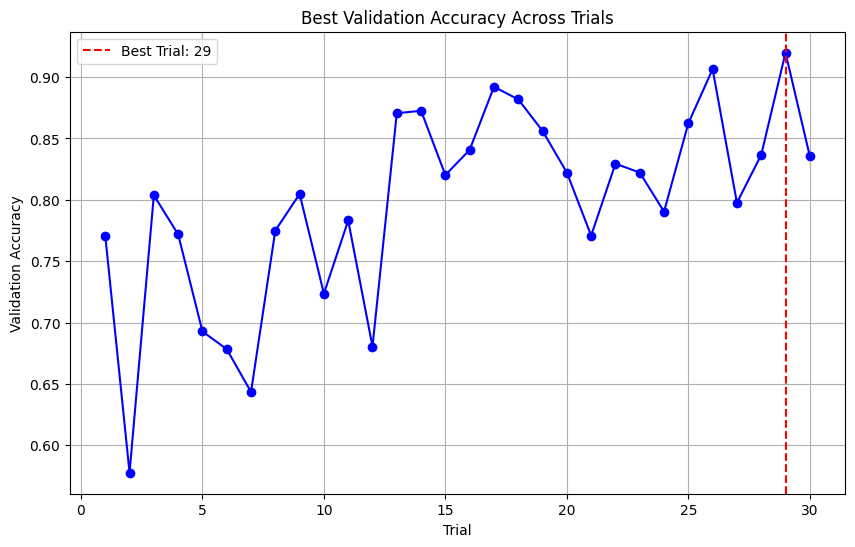

In [63]:
# Extract best validation accuracy from all trials
trial_ids = tuner.oracle.trials.keys()
best_val_accuracies = []

for trial_id in trial_ids:
    trial = tuner.oracle.get_trial(trial_id)
    # Extract val_accuracy values for the trial
    val_accuracies = [
        float(value) for obs in trial.metrics.get_history('val_accuracy') for value in obs.value
    ]
    # Get the maximum val_accuracy for this trial
    best_val_accuracy = max(val_accuracies)
    best_val_accuracies.append(best_val_accuracy)

# Find the highest validation accuracy and its corresponding trial
highest_val_accuracy = max(best_val_accuracies)  # max() now correctly identifies the highest float
highest_val_accuracy_trial = best_val_accuracies.index(highest_val_accuracy) + 1  # +1 to match trial indexing

print(f"Highest Validation Accuracy: {highest_val_accuracy:.4f}")
print(f"Occurred in Trial: {highest_val_accuracy_trial}")

# Plot validation accuracies and highlight the best trial
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_val_accuracies) + 1), best_val_accuracies, marker='o', linestyle='-', color='blue')
plt.axvline(x=highest_val_accuracy_trial, color='red', linestyle='--', label=f'Best Trial: {highest_val_accuracy_trial}')
plt.title('Best Validation Accuracy Across Trials')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()



Parameter Values Across Trials:
   Trial  conv1_filters  learning_rate Best Validation Accuracy
0   0000             48       0.000167      [0.770811915397644]
1   0001             16       0.000505      [0.577595055103302]
2   0002             64       0.000362     [0.8036999106407166]
3   0003             32       0.000764     [0.7718396782875061]
4   0004             16       0.000913     [0.6927030086517334]
5   0005             48       0.000587     [0.6783145070075989]
6   0006             16       0.000673      [0.643371045589447]
7   0007             48       0.000173     [0.7749229073524475]
8   0008             48       0.000211     [0.8047276735305786]
9   0009             16       0.000353     [0.7235354781150818]
10  0010             16       0.000187     [0.7831448912620544]
11  0011             32       0.000402     [0.6803699731826782]
12  0012             48       0.000211     [0.8705036044120789]
13  0013             64       0.000362     [0.8725590705871582]
14  001

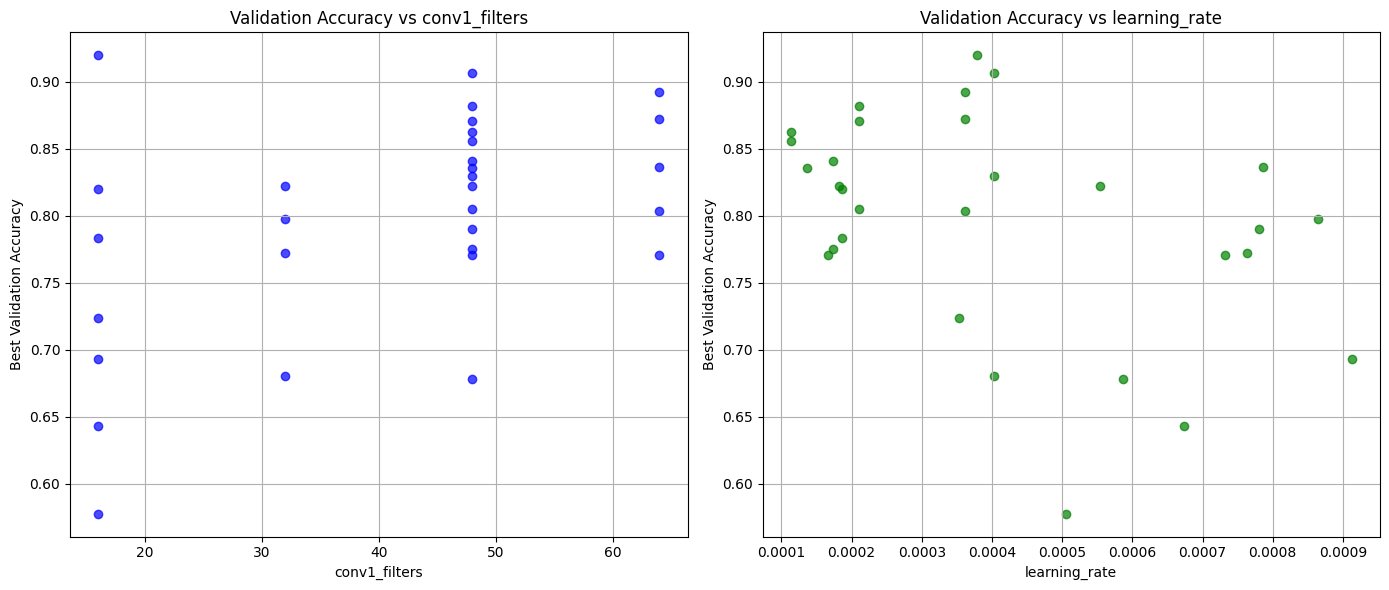

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract specific parameters and best validation accuracy
parameter_1 = []  # Replace with your desired parameter key (e.g., 'conv1_filters')
parameter_2 = []  # Replace with another parameter key (e.g., 'learning_rate')
best_val_accuracies = []

for trial_id in tuner.oracle.trials.keys():
    trial = tuner.oracle.get_trial(trial_id)
    hyperparams = trial.hyperparameters.values
    val_accuracies = [obs.value for obs in trial.metrics.get_history('val_accuracy')]
    best_val_accuracy = max(val_accuracies)
    best_val_accuracies.append(best_val_accuracy)
    parameter_1.append(hyperparams['conv1_filters'])  # Example parameter
    parameter_2.append(hyperparams['learning_rate'])  # Example parameter

# Display results in a tabular format
results_df = pd.DataFrame({
    'Trial': list(tuner.oracle.trials.keys()),
    'conv1_filters': parameter_1,
    'learning_rate': parameter_2,
    'Best Validation Accuracy': best_val_accuracies
})
print("\nParameter Values Across Trials:")
print(results_df)

# Plot relationships between parameters and best validation accuracy
plt.figure(figsize=(14, 6))

# Plot parameter 1 vs. accuracy
plt.subplot(1, 2, 1)
plt.scatter(parameter_1, best_val_accuracies, color='blue', alpha=0.7)
plt.title('Validation Accuracy vs conv1_filters')
plt.xlabel('conv1_filters')
plt.ylabel('Best Validation Accuracy')
plt.grid(True)

# Plot parameter 2 vs. accuracy
plt.subplot(1, 2, 2)
plt.scatter(parameter_2, best_val_accuracies, color='green', alpha=0.7)
plt.title('Validation Accuracy vs learning_rate')
plt.xlabel('learning_rate')
plt.ylabel('Best Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [47]:
# Extract and display hyperparameter values for each trial
trial_ids = tuner.oracle.trials.keys()

print("Trial Hyperparameters and Best Validation Accuracy:")
for trial_id in trial_ids:
    trial = tuner.oracle.get_trial(trial_id)
    hyperparams = trial.hyperparameters.values  # Extract hyperparameters as a dictionary
    best_val_accuracy = max([obs.value for obs in trial.metrics.get_history('val_accuracy')])  # Extract best val_accuracy
    print(f"Trial {trial_id}:")
    print(f"  Hyperparameters: {hyperparams}")
    print(f"  Best Validation Accuracy: {best_val_accuracy:.4f}")


Trial Hyperparameters and Best Validation Accuracy:
Trial 0000:
  Hyperparameters: {'conv1_filters': 48, 'conv2_filters': 64, 'dense_units': 64, 'dropout': 0.4, 'learning_rate': 0.00016659829711800065, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


TypeError: unsupported format string passed to list.__format__

# Hyperparameter Tuning

KeyError: 'test_accuracy'

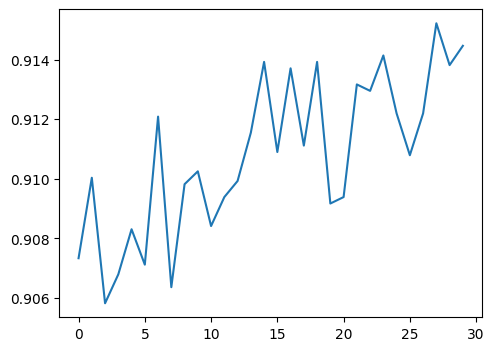

In [62]:
# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['test_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate and Print Metrics

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9281 - loss: 0.2093

Final Test Results:
Test Loss: 0.2277
Test Accuracy: 0.9219

Validation Accuracy for each epoch:
Epoch 1: 0.3638
Epoch 2: 0.7410
Epoch 3: 0.8654
Epoch 4: 0.8684
Epoch 5: 0.8561
Epoch 6: 0.8140
Epoch 7: 0.8931
Epoch 8: 0.8767
Epoch 9: 0.8983
Epoch 10: 0.8551
Epoch 11: 0.7174
Epoch 12: 0.8325
Epoch 13: 0.9116
Epoch 14: 0.9065
Epoch 15: 0.9106
Epoch 16: 0.9024
Epoch 17: 0.9137
Epoch 18: 0.9085
Epoch 19: 0.8808
Epoch 20: 0.9147
Epoch 21: 0.8972
Epoch 22: 0.9096
Epoch 23: 0.9003
Epoch 24: 0.9137
Epoch 25: 0.9198
Epoch 26: 0.9198
Epoch 27: 0.9229
Epoch 28: 0.9281
Epoch 29: 0.9198
Epoch 30: 0.9178


# TEST Accuracy

In [38]:
from tensorflow.keras.callbacks import Callback

# Custom callback to save test accuracy after each epoch
class TestAccuracyLogger(Callback):
    def __init__(self, test_data, test_labels):
        self.test_data = test_data
        self.test_labels = test_labels
        self.test_accuracies = []  # List to store test accuracy per epoch
        self.test_losses = []      # List to store test loss per epoch

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate the model on the test set
        test_loss, test_accuracy = self.model.evaluate(
            self.test_data, self.test_labels, verbose=0
        )
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Instantiate the callback
test_logger = TestAccuracyLogger(test_data, test_labels_encoded)

# Train the model with the callback
history = model.fit(
    train_data,
    train_labels_encoded,
    validation_data=(val_data, val_labels_encoded),
    epochs=30,
    batch_size=32,
    callbacks=[test_logger],
    verbose=1
)

# After training, you can access the test accuracy for each epoch
print("\nTest Accuracy for each epoch:")
for epoch, test_acc in enumerate(test_logger.test_accuracies, start=1):
    print(f"Epoch {epoch}: {test_acc:.4f}")

# Optional: Save test accuracy to a file
with open("test_accuracy_per_epoch.txt", "w") as f:
    for epoch, test_acc in enumerate(test_logger.test_accuracies, start=1):
        f.write(f"Epoch {epoch}: {test_acc:.4f}\n")


Epoch 1/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9028 - loss: 0.2595Epoch 1: Test Loss: 0.2236, Test Accuracy: 0.9250
289/289 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.9029 - loss: 0.2595 - val_accuracy: 0.9229 - val_loss: 0.2155
Epoch 2/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9131 - loss: 0.2550Epoch 2: Test Loss: 0.2313, Test Accuracy: 0.9229
289/289 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9131 - loss: 0.2550 - val_accuracy: 0.9239 - val_loss: 0.2158
Epoch 3/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9036 - loss: 0.2582Epoch 3: Test Loss: 0.2210, Test Accuracy: 0.9219
289/289 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.9036 - loss: 0.2582 - val_accuracy: 0.9260 - val_loss: 0.2158
Epoch 4/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9056 - loss: 0.2558Epoch 4: Test Loss: 0.2211, Test Accuracy: 0.9239
289/289 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9056 - loss: 0.2558 - val_accuracy: 0.9

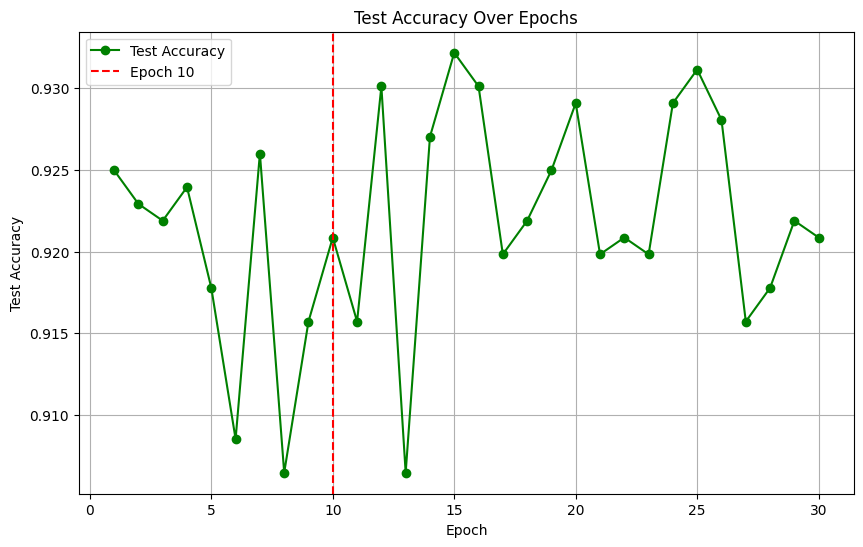

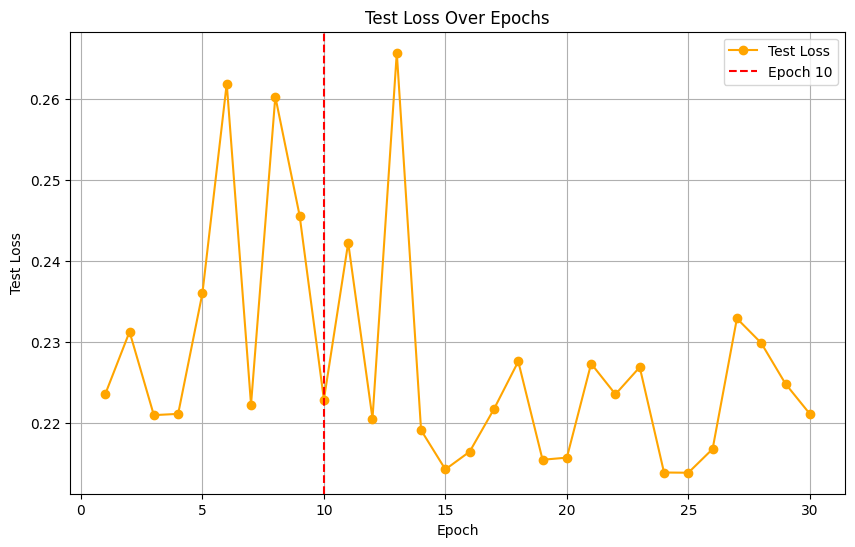

In [39]:
import matplotlib.pyplot as plt

# Assuming `test_logger` contains test accuracies and losses per epoch

# Plot Test Accuracy Over Epochs
epochs = range(1, len(test_logger.test_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, test_logger.test_accuracies, label='Test Accuracy', color='green', marker='o')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.axvline(10, color='red', linestyle='--', label='Epoch 10')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Loss Over Epochs (optional)
plt.figure(figsize=(10, 6))
plt.plot(epochs, test_logger.test_losses, label='Test Loss', color='orange', marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.axvline(10, color='red', linestyle='--', label='Epoch 10')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Extract results from the tuner
trials = tuner.oracle.get_best_trials()  # Get best trials instead of accessing all trials

results = []  # Initialize results list

# Iterate through trials and collect their hyperparameters and validation accuracies
for trial in trials:
    hyperparameters = trial.hyperparameters.values
    
    # Safely extract validation accuracy
    val_accuracy = None
    try:
        val_accuracy = trial.metrics.get('val_accuracy')
        if val_accuracy is not None:
            val_accuracy = val_accuracy.get_best_value()
    except Exception:
        pass

    # Collect trial information
    trial_result = {
        "Trial ID": trial.trial_id,  # Use trial_id attribute
        "Hyperparameters": hyperparameters,
        "Validation Accuracy": val_accuracy
    }
    results.append(trial_result)

# Display all results
print("Best Trials Results:")
for result in results:
    print(f"Trial ID: {result['Trial ID']}")
    print(f"Hyperparameters: {result['Hyperparameters']}")
    print(f"Validation Accuracy: {result['Validation Accuracy']:.4f}" if result['Validation Accuracy'] is not None else "Validation Accuracy: N/A")
    print("-" * 50)

Best Trials Results:
Trial ID: 0024
Hyperparameters: {'filters_block1': 32, 'filters_block2': 128, 'dense_units': 512, 'dropout_dense': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Validation Accuracy: N/A
--------------------------------------------------
